# Sarcasm and Irony detection
### RNN and LSTM

Dataset reference: https://www.kaggle.com/datasets/nikhiljohnk/tweets-with-sarcasm-and-irony

Name: Lucrezia Labardi

#### Import of libraries and dataset

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
%cd drive/MyDrive/UNI MAGISTRALE/Machine Learning/Labardi ML Exam

/content/drive/MyDrive/UNI MAGISTRALE/Machine Learning/Labardi ML Exam


In [34]:
import tensorflow.keras as keras
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

import torchtext
from sklearn.metrics import accuracy_score, f1_score, classification_report, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import torch
from torch import nn
import pandas as pd
import random

# import import_ipynb
import utils

from torch.nn.utils.rnn import pad_sequence, pack_padded_sequence

# to get reproducible results:
torch.manual_seed(1234)
np.random.seed(1234)

In [5]:
# did not import the original dataset but the preprocessed version
X = pd.read_csv("data/X_clean.csv")
y = pd.read_csv("data/y_clean.csv")
X_test = pd.read_csv("data/Xtest_clean.csv")
y_test = pd.read_csv("data/ytest_clean.csv")

In [6]:
X

,url,tags,num_hashtags,emojis,num_special,num_excl_quest,text_all_clean,n_char,n_words,avg_len_words
0,1,0,4,0,0,0,be aware dirty step to get money staylight sta...,64.0,11.0,5.818182
1,1,0,4,0,0,0,sarcasm for people who dont understand diy art...,45.0,8.0,5.625000
2,0,2,6,0,0,0,dailymail readers being sensible as always sho...,89.0,11.0,8.090909
3,0,1,1,0,0,1,why do i get the feeling you like games sarcasm,38.0,10.0,3.800000
4,0,2,1,0,0,0,you probably just missed the text sarcastic,37.0,7.0,5.285714
...,...,...,...,...,...,...,...,...,...,...
81349,1,0,4,0,0,0,photo image via we heart it childhood cool fun...,47.0,10.0,4.700000
81350,1,0,2,0,0,0,i never knewi better put this out to the unive...,88.0,20.0,4.400000
81351,0,0,2,0,0,0,hey just wanted to say thanks puberty for lett...,102.0,23.0,4.434783
81352,1,0,1,0,0,0,im sure coverage like the fox news special the...,88.0,18.0,4.888889


In [7]:
X_test

,url,tags,num_hashtags,emojis,num_special,num_excl_quest,text_all_clean,n_char,n_words,avg_len_words
0,1,0,1,0,0,0,no one ever predicted this was going to happen...,45.0,10.0,4.500000
1,0,1,1,0,0,0,its as closely related as andrews original cla...,71.0,13.0,5.461538
2,0,0,1,0,0,0,i find it ironic when vegans say they love foo...,43.0,11.0,3.909091
3,0,0,1,0,0,0,quick rt that throwing money vine ive not seen...,72.0,18.0,4.000000
4,0,0,4,0,0,0,yep keep adding me to your devops lists justsa...,54.0,11.0,4.909091
...,...,...,...,...,...,...,...,...,...,...
8114,0,0,1,0,0,0,why yes i will totally submit my photos to a s...,110.0,26.0,4.230769
8115,1,0,1,0,0,2,test on a saturday thank you uni sarcasm griff...,63.0,12.0,5.250000
8116,0,1,1,0,0,0,listening to s misery isnt at all disconcertin...,47.0,9.0,5.222222
8117,0,1,2,0,0,0,there you go being kind again sarcasm standup4...,43.0,8.0,5.375000


In [8]:
#only select the text part
X_text = X["text_all_clean"]
X_test_text = X_test["text_all_clean"]

#### Preprocessing of the data

In [9]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()

In [10]:
# encode the labels to numbers
y = le.fit_transform(y["class"])
y_test = le.transform(y_test["class"])

In [11]:
from sklearn.model_selection import train_test_split

# create a validation set, with size 10% of the training set, stratified
X_text, X_dev_text, y, y_dev = train_test_split(X_text, y, test_size=0.1, random_state=42, stratify=y)

In [12]:
X_text.shape, X_dev_text.shape, X_test_text.shape, y.shape, y_dev.shape, y_test.shape

((73218,), (8136,), (8119,), (73218,), (8136,), (8119,))

In [13]:
# check the mapping of the label encoder
print("Class mapping:", dict(zip(le.classes_, le.transform(le.classes_))))

Class mapping: {'figurative': 0, 'irony': 1, 'regular': 2, 'sarcasm': 3}


In [14]:
# initialize a tokenizer and fit it to the training data
from keras.preprocessing.text import Tokenizer
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_text)

# get word index and vocabulary size
word_index = tokenizer.word_index
vocab_size = len(word_index)
vocab_size

66370

In [15]:
# create a reverse word index with 4 more values for special tokens
reverse_word_index = dict([(value+3, key) for (key, value) in word_index.items()])

reverse_word_index[0] = '[PAD]'
reverse_word_index[1] = '[START]'
reverse_word_index[2] = '[UNK]'
reverse_word_index[3] = '[UNS]'

In [16]:
# transform the sentences into sequences of numbers (corresponding to the same word index)
seq_train = tokenizer.texts_to_sequences(X_text)
seq_dev = tokenizer.texts_to_sequences(X_dev_text)
seq_test = tokenizer.texts_to_sequences(X_test_text)

In [17]:
print(max(len(data) for data in seq_train))
print(max(len(data) for data in seq_dev))
print(max(len(data) for data in seq_test))

34
34
31


In [18]:
seq_test[0] # sentences look like this

[52, 62, 172, 3828, 18, 30, 115, 3, 757, 2]

In [19]:
y_test[0]

0

In [20]:
from torch.nn.utils.rnn import pad_sequence
import torch

#max_len mus be the same for every sequence. I decided to reduce to 30 since the mex length is 34, 34 and 31
max_len = 30

train_data = [sent[:max_len] for sent in seq_train]
dev_data = [sent[:max_len] for sent in seq_dev]
test_data = [sent[:max_len] for sent in seq_test]

x_train = pad_sequence([torch.tensor(sent) for sent in train_data], batch_first=True)
x_dev = pad_sequence([torch.tensor(sent) for sent in dev_data], batch_first=True)
x_test = pad_sequence([torch.tensor(sent) for sent in test_data], batch_first=True)


In [21]:
x_train[0] # now sentences look like this

tensor([  169,   117,    67,   103,     5,   212,     7,   350,     9,  6474,
            1, 31644,    68,   397,  3637,    56,   566,  7485,     4,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0])

In [22]:
print(max(len(data) for data in x_train))
print(max(len(data) for data in x_dev))
print(max(len(data) for data in x_test))

30
30
30


In [23]:
x_test

tensor([[   52,    62,   172,  ...,     0,     0,     0],
        [   31,    53, 11412,  ...,     0,     0,     0],
        [    6,   175,    16,  ...,     0,     0,     0],
        ...,
        [  459,     3,   302,  ...,     0,     0,     0],
        [   96,    12,    99,  ...,     0,     0,     0],
        [   36,   527,    14,  ...,     0,     0,     0]])

In [24]:
def np2iter(x, y, shuffle=True):

  y = torch.tensor(y, dtype=torch.long)


  ds = torch.utils.data.TensorDataset(x, y)
  return torch.utils.data.DataLoader(ds, batch_size=64, shuffle=shuffle)

train_iter = np2iter(x_train, y, shuffle=True)
dev_iter =  np2iter(x_dev, y_dev, shuffle=False)
test_iter =  np2iter(x_test, y_test, shuffle=False)

In [25]:
# must be 66374 because the vocabulary is 66370 and we added 4 more special tokens
num_words = 66374

In [26]:
max_len

30

### Multilayer Perceptron

In [27]:
class FlatModel(nn.Module):
  def __init__(self, emb_dim=50):
    super(FlatModel, self).__init__()

    self.embeddings = nn.Embedding(num_embeddings=num_words,
                                   embedding_dim=emb_dim, padding_idx=0)

    self.layer = nn.Sequential(nn.Linear(in_features=emb_dim*max_len, out_features=emb_dim),
                                nn.ReLU(),
                                nn.Linear(in_features=emb_dim, out_features=4))


  def forward(self, x):
    x = self.embeddings(x)
    x = torch.flatten(x, start_dim=1, end_dim=- 1)
    return self.layer(x)

In [28]:
def val_acc(y_pred, y_test):
  y_pred = np.argmax(y_pred, axis=1)
  return accuracy_score(y_pred=y_pred, y_true=y_test)

In [29]:
import torch
print(torch.__version__)
print(torch.cuda.is_available())

2.1.0+cu121
True


In [30]:
flat_model = FlatModel(emb_dim=300)
flat_model = flat_model.cuda()

In [31]:
history = utils.train(model=flat_model,
              loss=nn.CrossEntropyLoss(),
              val_metrics={"cls": nn.CrossEntropyLoss(), "acc": val_acc},
              optimizer=torch.optim.Adam(flat_model.parameters(), lr=0.0001),
              train_ds=train_iter,
              dev_ds=dev_iter,
              num_epochs=30,
              early_stopper=utils.EarlyStopper(metric_name="cls", patience=3))

epoch 1 train loss: 0.7197 val_cls: 0.5802 val_acc: 0.7046
tensor(0.5802) None
epoch 2 train loss: 0.5141 val_cls: 0.5889 val_acc: 0.6794
tensor(0.5889) tensor(0.5802)
epoch 3 train loss: 0.4746 val_cls: 0.6294 val_acc: 0.6608
tensor(0.6294) tensor(0.5802)
epoch 4 train loss: 0.4424 val_cls: 0.6874 val_acc: 0.6180
tensor(0.6874) tensor(0.5802)
EARLY STOPPING 


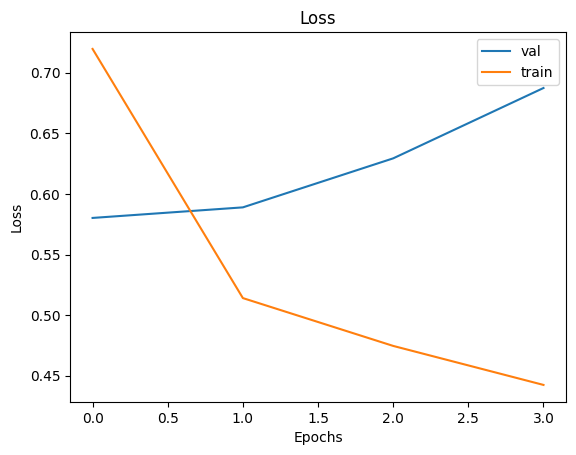

In [32]:
plt.plot(history['val_cls'],  label='val')
plt.plot(history['train_loss'], label='train')
plt.title('Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [33]:
pred = utils.test(flat_model, test_iter)
pred = np.argmax(pred, axis=1)

pred_true = le.inverse_transform(pred)
y_true = le.inverse_transform(y_test)

print(classification_report(y_pred=pred_true, y_true=y_true))

              precision    recall  f1-score   support

  figurative       0.16      0.03      0.05      2044
       irony       0.66      0.91      0.77      2111
     regular       0.97      0.99      0.98      1859
     sarcasm       0.67      0.93      0.78      2105

    accuracy                           0.71      8119
   macro avg       0.61      0.72      0.64      8119
weighted avg       0.61      0.71      0.64      8119



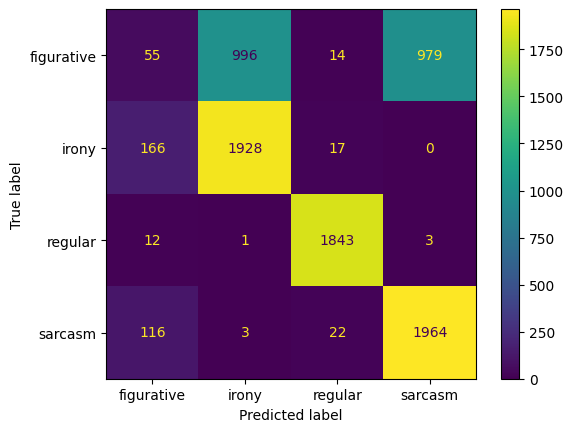

In [35]:
ConfusionMatrixDisplay.from_predictions(y_true, pred_true);

In [36]:
sum(p.numel() for p in flat_model.parameters() if p.requires_grad)

22613704

### Simple RNN

In [37]:
class SimpleRNN(nn.Module):
  def __init__(self, emb_dim=50):
    super(SimpleRNN, self).__init__()

    self.embeddings = nn.Embedding(num_embeddings=num_words,
                                   embedding_dim=emb_dim, padding_idx=0)

    self.rnn = nn.RNN(input_size=emb_dim, hidden_size=emb_dim, num_layers=1,
                      batch_first=True)

    self.linear_layer = nn.Linear(in_features=emb_dim, out_features=4)


  def forward(self, x):
    # our sequences have different lengths; let's calculate it
    len_x = (x !=0).sum(1)

    x = self.embeddings(x)
    # this function packs our padded sequences and later
    #  makes sure that our RNNs do not read the padded part
    x = pack_padded_sequence(x, len_x.cpu(), batch_first=True,
                             enforce_sorted=False)

    #  we extract the last hidden state
    _, x = self.rnn(x)

    x = x[0]
    return self.linear_layer(x)

In [38]:
simple_rnn = SimpleRNN(emb_dim=300)

simple_rnn = simple_rnn.cuda()

history = utils.train(model=simple_rnn,
              loss=nn.CrossEntropyLoss(),
              val_metrics={"cls": nn.CrossEntropyLoss(), "acc": val_acc},
              optimizer=torch.optim.Adam(simple_rnn.parameters(), lr=0.0001),
              train_ds=train_iter,
              dev_ds=dev_iter,
              num_epochs=20,
              early_stopper=utils.EarlyStopper(metric_name="cls", patience=3))

epoch 1 train loss: 0.6161 val_cls: 0.5429 val_acc: 0.7301
tensor(0.5429) None
epoch 2 train loss: 0.5308 val_cls: 0.5311 val_acc: 0.7334
tensor(0.5311) tensor(0.5429)
epoch 3 train loss: 0.5146 val_cls: 0.5262 val_acc: 0.7325
tensor(0.5262) tensor(0.5311)
epoch 4 train loss: 0.5051 val_cls: 0.5268 val_acc: 0.7285
tensor(0.5268) tensor(0.5262)
epoch 5 train loss: 0.4984 val_cls: 0.5276 val_acc: 0.7274
tensor(0.5276) tensor(0.5262)
epoch 6 train loss: 0.4926 val_cls: 0.5389 val_acc: 0.7228
tensor(0.5389) tensor(0.5262)
EARLY STOPPING 


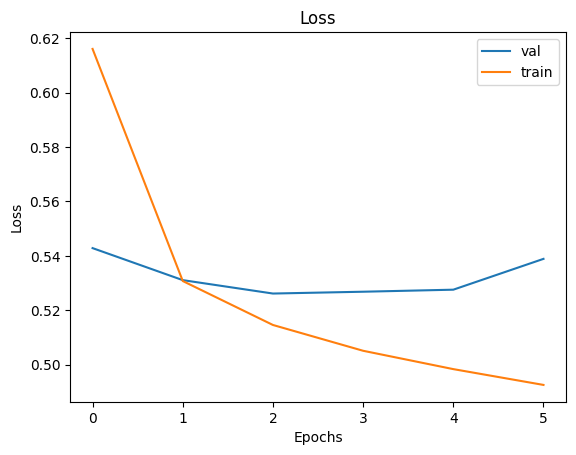

In [39]:
plt.plot(history['val_cls'],  label='val')
plt.plot(history['train_loss'], label='train')
plt.title('Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [40]:
pred = utils.test(simple_rnn, test_iter)
pred = np.argmax(pred, axis=1)
pred_true = le.inverse_transform(pred)
print(classification_report(y_pred=pred_true, y_true=y_true))

              precision    recall  f1-score   support

  figurative       0.25      0.01      0.02      2044
       irony       0.67      0.97      0.79      2111
     regular       0.99      0.99      0.99      1859
     sarcasm       0.67      0.98      0.80      2105

    accuracy                           0.74      8119
   macro avg       0.65      0.74      0.65      8119
weighted avg       0.64      0.74      0.65      8119



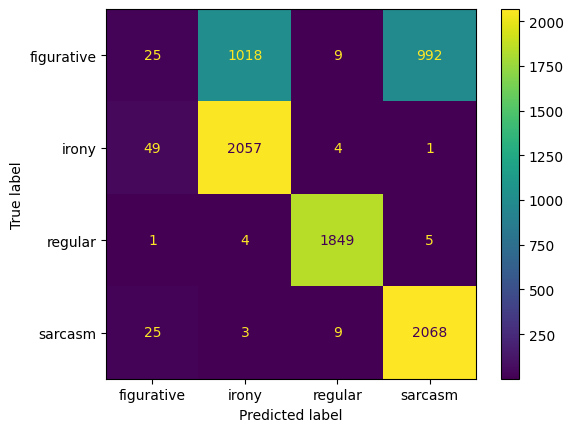

In [41]:
ConfusionMatrixDisplay.from_predictions(y_true, pred_true);

### LSTM

In [42]:
class LSTM(nn.Module):
  def __init__(self, emb_dim=50):
    super(LSTM, self).__init__()

    self.embeddings = nn.Embedding(num_embeddings=num_words,
                                   embedding_dim=emb_dim, padding_idx=0)

    self.rnn = nn.LSTM(input_size=emb_dim, hidden_size=emb_dim, num_layers=1,
                      batch_first=True)

    self.linear_layer = nn.Linear(in_features=emb_dim, out_features=4)


  def forward(self, x):
    # our sequences have different lengths; let's calculate it
    len_x = (x !=0).sum(1)


    x = self.embeddings(x)

    # this function packs our padded sequences and later
    #  makes sure that our RNNs do not read the padded part
    x = pack_padded_sequence(x, len_x.cpu(), batch_first=True,
                             enforce_sorted=False)
    #  we extract the last hidden state
    _, (x, _) = self.rnn(x)
    x = x[0]
    return self.linear_layer(x)

In [43]:
lstm = LSTM(emb_dim=300)

lstm = lstm.cuda()

history = utils.train(model=lstm,
              loss=nn.CrossEntropyLoss(),
              val_metrics={"cls": nn.CrossEntropyLoss(), "acc": val_acc},
              optimizer=torch.optim.Adam(lstm.parameters(), lr=0.0001),
              train_ds=train_iter,
              dev_ds=dev_iter,
              num_epochs=20,
              early_stopper=utils.EarlyStopper(metric_name="cls", patience=3))

epoch 1 train loss: 0.5875 val_cls: 0.5079 val_acc: 0.7360
tensor(0.5079) None
epoch 2 train loss: 0.5025 val_cls: 0.5076 val_acc: 0.7357
tensor(0.5076) tensor(0.5079)
epoch 3 train loss: 0.4969 val_cls: 0.5099 val_acc: 0.7364
tensor(0.5099) tensor(0.5076)
epoch 4 train loss: 0.4927 val_cls: 0.5114 val_acc: 0.7311
tensor(0.5114) tensor(0.5076)
epoch 5 train loss: 0.4882 val_cls: 0.5166 val_acc: 0.7258
tensor(0.5166) tensor(0.5076)
EARLY STOPPING 


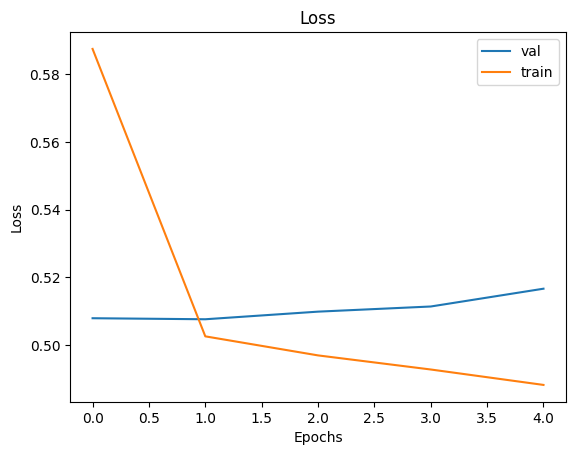

In [44]:
plt.plot(history['val_cls'],  label='val')
plt.plot(history['train_loss'], label='train')
plt.title('Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [45]:
pred = utils.test(lstm, test_iter)
pred = np.argmax(pred, axis=1)
pred_true = le.inverse_transform(pred)

print(classification_report(y_pred=pred_true, y_true=y_true))

              precision    recall  f1-score   support

  figurative       0.29      0.00      0.00      2044
       irony       0.67      1.00      0.80      2111
     regular       0.99      1.00      0.99      1859
     sarcasm       0.68      0.99      0.80      2105

    accuracy                           0.75      8119
   macro avg       0.66      0.75      0.65      8119
weighted avg       0.65      0.75      0.65      8119



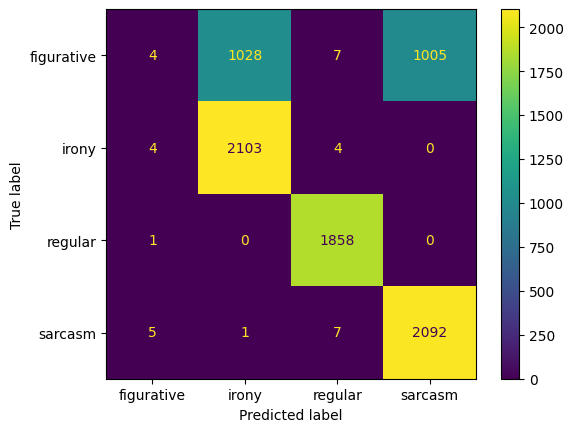

In [46]:
ConfusionMatrixDisplay.from_predictions(y_true, pred_true);

In [47]:
sum(p.numel() for p in LSTM(300).parameters() if p.requires_grad)

20635804

#### LSTM with pretrained GloVe embeddings

In [48]:
glove_vectors = torchtext.vocab.GloVe('6B', dim=50)

In [49]:
lstm = LSTM(emb_dim=300)

emb_matrix = utils.build_embed_matrix(reverse_word_index=reverse_word_index,
                                      dim=300, num_words=num_words)

lstm.embeddings.from_pretrained(emb_matrix, freeze=False)
lstm = lstm.cuda()

history = utils.train(model=lstm,
              loss=nn.CrossEntropyLoss(),
              val_metrics={"cls": nn.CrossEntropyLoss(), "acc": val_acc},
              optimizer=torch.optim.Adam(lstm.parameters(), lr=0.0001),
              train_ds=train_iter,
              dev_ds=dev_iter,
              num_epochs=20,
              early_stopper=utils.EarlyStopper(metric_name="cls", patience=3))

epoch 1 train loss: 0.5930 val_cls: 0.5112 val_acc: 0.7365
tensor(0.5112) None
epoch 2 train loss: 0.5034 val_cls: 0.5085 val_acc: 0.7357
tensor(0.5085) tensor(0.5112)
epoch 3 train loss: 0.4976 val_cls: 0.5083 val_acc: 0.7357
tensor(0.5083) tensor(0.5085)
epoch 4 train loss: 0.4939 val_cls: 0.5103 val_acc: 0.7353
tensor(0.5103) tensor(0.5083)
epoch 5 train loss: 0.4896 val_cls: 0.5170 val_acc: 0.7330
tensor(0.5170) tensor(0.5083)
epoch 6 train loss: 0.4841 val_cls: 0.5266 val_acc: 0.7217
tensor(0.5266) tensor(0.5083)
EARLY STOPPING 


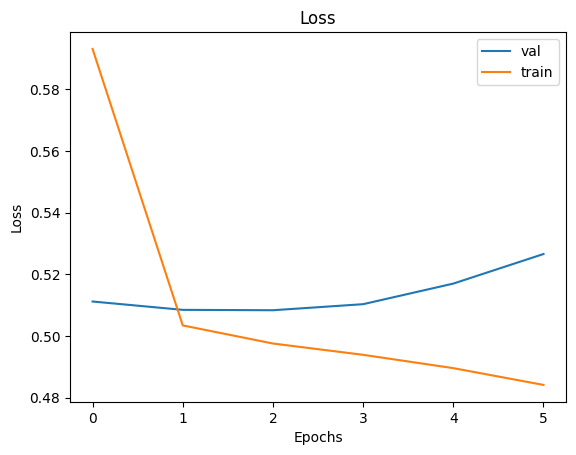

In [50]:
plt.plot(history['val_cls'],  label='val')
plt.plot(history['train_loss'], label='train')
plt.title('Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [51]:
pred = utils.test(lstm, test_iter)
pred = np.argmax(pred, axis=1)
pred_true = le.inverse_transform(pred)
print(classification_report(y_pred=pred_true, y_true=y_true))

              precision    recall  f1-score   support

  figurative       0.33      0.00      0.00      2044
       irony       0.67      1.00      0.80      2111
     regular       1.00      1.00      1.00      1859
     sarcasm       0.68      1.00      0.80      2105

    accuracy                           0.75      8119
   macro avg       0.67      0.75      0.65      8119
weighted avg       0.66      0.75      0.65      8119



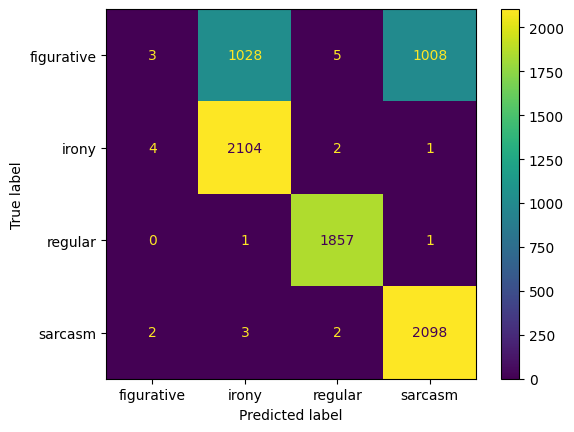

In [52]:
ConfusionMatrixDisplay.from_predictions(y_true, pred_true);

#### LSTM with random embeddings

In [53]:
lstm = LSTM(emb_dim=300)

lstm.embeddings.weight.requires_grad = False

lstm = lstm.cuda()

history = utils.train(model=lstm,
              loss=nn.CrossEntropyLoss(),
              val_metrics={"cls": nn.CrossEntropyLoss(), "acc": val_acc},
              optimizer=torch.optim.Adam(lstm.parameters(), lr=0.0001),
              train_ds=train_iter,
              dev_ds=dev_iter,
              num_epochs=20,
              early_stopper=utils.EarlyStopper(metric_name="cls", patience=3))

epoch 1 train loss: 0.5940 val_cls: 0.5155 val_acc: 0.7355
tensor(0.5155) None
epoch 2 train loss: 0.5051 val_cls: 0.5070 val_acc: 0.7360
tensor(0.5070) tensor(0.5155)
epoch 3 train loss: 0.4990 val_cls: 0.5068 val_acc: 0.7356
tensor(0.5068) tensor(0.5070)
epoch 4 train loss: 0.4961 val_cls: 0.5077 val_acc: 0.7359
tensor(0.5077) tensor(0.5068)
epoch 5 train loss: 0.4931 val_cls: 0.5096 val_acc: 0.7359
tensor(0.5096) tensor(0.5068)
epoch 6 train loss: 0.4898 val_cls: 0.5171 val_acc: 0.7346
tensor(0.5171) tensor(0.5068)
EARLY STOPPING 


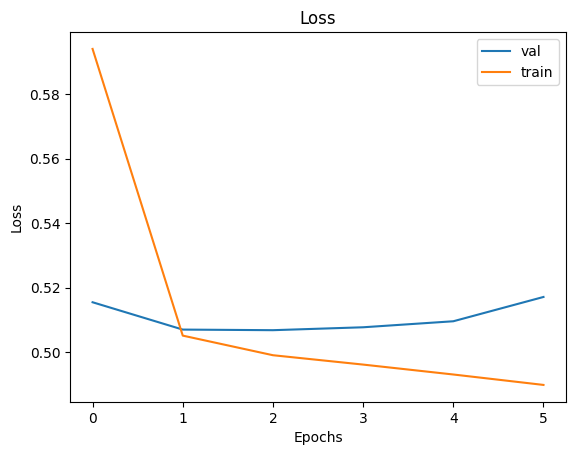

In [54]:
plt.plot(history['val_cls'],  label='val')
plt.plot(history['train_loss'], label='train')
plt.title('Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [55]:
pred = utils.test(lstm, test_iter)
pred = np.argmax(pred, axis=1)
pred_true = le.inverse_transform(pred)

print(classification_report(y_pred=pred_true, y_true=y_true))

              precision    recall  f1-score   support

  figurative       0.30      0.00      0.00      2044
       irony       0.67      1.00      0.80      2111
     regular       0.99      1.00      1.00      1859
     sarcasm       0.67      0.99      0.80      2105

    accuracy                           0.75      8119
   macro avg       0.66      0.75      0.65      8119
weighted avg       0.65      0.75      0.65      8119



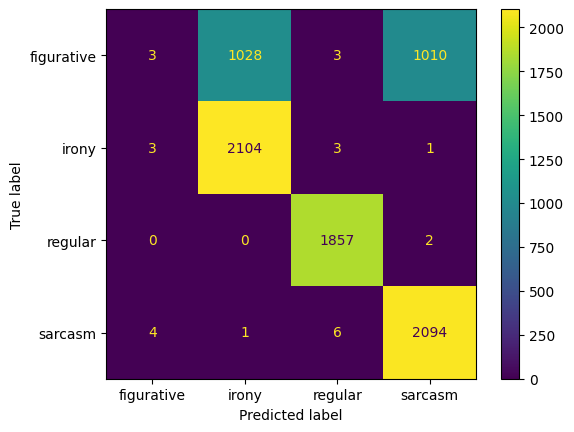

In [56]:
ConfusionMatrixDisplay.from_predictions(y_true, pred_true);